# Distortion Method Induction

This is the inductive algorithm from the paper:<br> "*Deterministic Sequence Matching for Pipeline Inspection Run Comparisons*"<br> by Craig L Champlin (cchampli@mines.edu) and Salman Mohagheghi

Submited for publication in:<br>
**the *International Journal of Pressure Vessels and Piping***

### Using this notebook:
Code notebooks, such as this one, blend working code and documentation in a way that supports tremendous clarity and experimentation. If you have never used one before, there are a few things to be aware of...

Code sections must explicitly be executed

  * order matters
      * the first two sections, importing packages and importing data, need to run once
      * functions must be run before `main() `will work
      * other than that, not all sections need to be run

    

* The scope of variables outside of functions is global

  * The order in the document doesn't matter
  * One might change a value and cause previous sections to break
  * to fix this, rerun sections in order

### Things to try

This is a table of things to try while you are here

| What | Where | How | Shows |
| :---- | :----- | :----- | :----- |
| Disable scanw() | `Configuration (07)` | toggle `runScanw` | * uncorected matching<br> * be sure to compare the graphs with and w/out `scanw()` |
| Swich data sets | `import_data (02)` | uncomment dataset | * shows 4 data sets from the paper<br> * RC2 has lots of reroutes so it is a random walk  |
| Tighten $\mathring{\varepsilon}$ threshold | `Configuration (07)` | alter `etMonoVal` | * number of rows sacrificed for precision<br> * compare row count after section `(09)` |



### A note on data availability :
Recent news about the bombing of the Nordstream pipeline, as well as other acts of vandalism or terror, should make it clear that pipeline data is extremely sensitive. To that end, we have taken the following steps to obscure the data offered here :

1. We have released a minimal data set to support the induction only. There are only two columns for each event, odometry and event class. 
2. Event class values for reference points have been randomly aggregated. This has reduced the precision of the results that this data can generate since what may have been three different types of reference points, are now represented by only one.
3. The original index values are not included because they imply the amount of corrosion on a joint. This information could be misused.
4. Data for the hybrid method, using semantic Needleman-Wunsch, is too sensitive for release. It requires all columns from the event attribute vector. We are contemplating how to generate a synthetic data set for this.


## Version History


#### `2023 05 06` Make Headless
* Adapt to headless operation for CodeOcean

#### `2022 11 28` Revision
* bug : Capture lowest differencing in scanw()
* bug : Role `holdB` was finding wrong sign for differencing
* new : improved messaging output for main
* new : improved internal documentation
* bug : index selection after scanw() in main was wrong

#### `2022 11 16` Bug Fix
* bug: Typo in scanw()

#### `2022 10 15` Public Version
* new : Adding comments

#### `2022 10 12` Public Version
* Streamline for public release


#### `2022 10 06` Clean Version
* Following the published algorithm
* Using the recursion in `incrik()`


(c) 2022-2023, Craig L Champlin<br>
LICENSE: GNU Affero General Public License v3.0<br>
https://choosealicense.com/licenses/agpl-3.0/

# Initializations - Run once

In [2]:
#### Initialize_packages
## Run this to start a session
## Label 01

import math
import numpy as np
import pandas as pd

from collections import deque

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [3]:
#### Import_data
## Run this to start a session
## Label 02

# Uncomment a row to choose dataset 
###
# dset = 'RC1'; AStartRow=3; BStartRow=2; AEndRow=3913; BEndRow=3865
# dset = 'RC2'; AStartRow=4; BStartRow=6; AEndRow=12875; BEndRow=12375  
# dset = 'RC2'; AStartRow=6896; BStartRow=6556; AEndRow=12875; BEndRow=12375  # 2nd half
dset = 'RC3'; AStartRow=3; BStartRow=3; AEndRow=7902; BEndRow=7757
# dset = 'RC4'; AStartRow=0; BStartRow=0; AEndRow=388; BEndRow=386

# import data
fnameA = ('../data/' + dset + '-A.csv')
fnameB = ('../data/' + dset + '-B.csv')

colNames = ['wc','event']

dfA = pd.read_csv(fnameA, skiprows=2, header=0, names=colNames)
dfB = pd.read_csv(fnameB, skiprows=2, header=0, names=colNames)

# lowercase-erize strings for easy comparison
dfA['event']=dfA['event'].str.lower()
dfB['event']=dfB['event'].str.lower()

# cast as specific data types to keep things tidy
eventTypes = pd.CategoricalDtype(categories=['refpoint1',
                                             'refpoint2',
                                             'refpoint3',
                                             'refpoint4',
                                             'refpoint5',
                                             'weld'], ordered=False)

dataTypes = {
             'event':eventTypes,
             'wc':np.float_
             }

dfA.astype(dataTypes)
dfB.astype(dataTypes)

# visual confirmation
print('Survey A')
display(dfA)
print('\nSurvey B')
display(dfB)

Survey A


,wc,event
0,-8.56,refpoint2
1,-2.13,weld
2,-1.66,refpoint3
3,0.00,refpoint5
4,0.51,refpoint3
...,...,...
7901,296374.61,refpoint3
7902,296375.42,refpoint5
7903,296376.27,refpoint3
7904,296376.68,weld



Survey B


,wc,event
0,-52.94,refpoint2
1,-1.29,weld
2,-0.87,refpoint3
3,0.00,refpoint5
4,0.95,refpoint3
...,...,...
7756,296086.44,refpoint3
7757,296087.40,refpoint5
7758,296088.38,refpoint3
7759,296088.78,weld


In [4]:
#### display rows example
# How to display rows - for looking at data
## Label 03

print(dfA.loc[100:105])
print()
print(dfB.loc[100:105])

          wc event
100  2451.56  weld
101  2491.80  weld
102  2532.11  weld
103  2572.43  weld
104  2612.67  weld
105  2652.99  weld

          wc      event
100  2819.76  refpoint5
101  2821.21  refpoint4
102  2851.57       weld
103  2891.88       weld
104  2932.21       weld
105  2971.20  refpoint4


# Distortion Method Code

Per the paper

### Configuration is below the two functions
It is above the main routine so that it is convienient to tweak parameters and try them out.

## Functions - Run once

Run these once to load them into the application space

In [5]:
#### incrik()
## Run Once
## Label 04

def incrik(i,k,A,B,Dm1,W) :
    # increment i and k, matching event types only
    i = i + 1 ; k = k + 1
    
    ei = A.loc[i].loc['event']
    ek = B.loc[k].loc['event']
    
    # easy match, exit
    if (ei == ek) :
        return (i,k)
    
    # no match, look for one nearby
    xi = A.loc[i].loc['wc']
    xk = B.loc[k].loc['wc']
    
    ip = i ; kp = k
    
    nearb = True 
    while nearb :   # hold A, scan B
        kp = kp + 1
        xkp = B.loc[kp].loc['wc']
        ekp = B.loc[kp].loc['event']
        
        nearb = (ei != ekp) and (xkp - xk) < W and (kp < len(B)-1)
        
    neara = True
    while neara :   # hold B, scan A
        ip = ip + 1
        xip = A.loc[ip].loc['wc']
        eip = A.loc[ip].loc['event']
    
        neara = (eip != ek) and (xip - xi) < W and (ip < len(A)-1)
    
        
    if (ei != ekp) and (eip != ek) :  
        # no match found, recurse until match
        print('incrik : xi = ', xi, '\ti = ', i, '\trecursing to find a match')
        return incrik(i,k,A,B,Dm1,W)
    
    # one or more candidate pairs
    if (ei == ekp) and (eip == ek) :
        # dual matches
        DiA = xi - xkp ; DDiA = DiA - Dm1
        DkB = xip - xk ; DDkB = DkB - Dm1
        
        if abs(DDiA) < abs(DDkB) :
            return (i, kp)
        else :
            return (ip, k)
        
    if (ei == ekp) :
        # single match
        return (i, kp)
    else :
        return (ip, k)
    
    # error
    print('ERROR: i = ', i, '\tk = ', k, '\tei = ', ei, '\teip = ', eip, '\tek = ', ek, '\tekp = ', ekp)
    return(i,k)
#     return(AEndRow,BEndRow)

In [6]:
#### scanw()
## Run Once
## Label 05

def scanw(i,k,A,B,Dm1,DD,et,psi,role) :
    # returns index of better match within w
    w = abs(DD) * psi
    bestk = k 
    bestDD = float('+inf')
     
    xi = A.loc[i].loc['wc']
    xk = B.loc[k].loc['wc']
    ei = A.loc[i].loc['event']
    ek = B.loc[k].loc['event']
    
    kp = k + 1
    
    nearby = True
    while nearby :
        
        xkp = B.loc[kp].loc['wc'] 
        ekp = B.loc[kp].loc['event'] 
        
        if (ei == ekp) :
            if role == 'holdA' :
                Dp = xi - xkp
            elif role == 'holdB' :
                Dp = xkp - xi
            else :
                pass
            
            DDp = Dp - Dm1
            
            if (abs(DDp) < abs(DD)) and (abs(DDp) < et[ei]) and (abs(DDp) < bestDD) :
                # better match found, 
                bestk = kp
                bestDD = abs(DDp)
                
                print(role,' : xi = ', xi,
                      '\ti = ', i, '\tk = ', k, '\tkp = ', kp,
                     '\tDD = ', round(DD,1), '\tDDp = ', round(DDp,1))
                
                
        kp = kp + 1
        nearby = (xkp - xk) < w  and (kp < len(B)-1)
    
    return bestk

In [7]:
#### distortion() 
## Run Once
## Label 06

def distortion (i, k ) :
    # return the distortion between two rows
    
    xa = dfA.loc[i].loc['wc']
    xb = dfB.loc[k].loc['wc']
    
    return (xa - xb)

## Configuration

All configurable parameters are here

**note:** `main()` consumes the indices. Rerun the config every time.

In [8]:
#### Configurations
## Label 07
#
# these are globally available
#   - avoid mistakes by pretending that they are not

### Run this every time
#
# main() consumes i and k, need to refresh
#
# symptom: One line output with i and k at max values

#### Good settings per example
## RC1
# bigW = 53
# psi = 1.3
# etMonoVal = 2.0
# row count 3751 rows
#
## RC2
# Major reroutes, output is random walk
#
## RC3
bigW = 33
psi = 1.3
etMonoVal = 5.3
# row count 7633 rows
#
## RC4
# bigW = 45
# psi = 1.3
# etMonoVal = 2.0
# row count 379 rows

### toggle the use of scanw 
runScanw = True
# runScanw = False

# target error threshold (\mathring{\varepsilon})
# etMonoVal = 10.3                   # real
et = {'refpoint1':etMonoVal,
      'refpoint2':etMonoVal,
      'refpoint3':etMonoVal,
      'refpoint4':etMonoVal,
      'refpoint5':etMonoVal,
      'weld':etMonoVal}

# Capital W window (about the size of longest joints)
# bigW = 243                      # real

# scan window factor of safety (w = DD * psi)
# psi = 11.3                     # real

# boundary conditions
i = AStartRow
k = BStartRow

n = AEndRow
m = BEndRow


## Main routine

This may take a while.

It will say `Finished` when it is done.

If it finishes instantly, it is likely that you forgot to run the initilizations.  Try this before freaking out.

In [9]:
#### main()
## Label 08
if i > 10 :
    print('Did you remember to initialize the configuration?\n\n')

D = distortion(i, k)
DD = 0
match = True

S = deque()      # the output sequence

## Main Loop
while (i < n-1) and (k < m-1) :

    if match :
        S.append([i,k,D,DD])
        Dm1 = D  # last known good distortion value
    else :
        xi = dfA.loc[i].loc['wc']
        print('pass   : xi = ', xi,'\ti = ', i, '\tk = ', k, '\tD = ', round(D,1), '\tDD = ', round(DD,1))
        pass     # outlier, retain last Dm1

    match = False

    # get next pair of i and k
    i, k = incrik(i,k,dfA,dfB,Dm1,bigW) 
    
    ei = dfA.loc[i].loc['event']
    ek = dfB.loc[k].loc['event']

    xi = dfA.loc[i].loc['wc']
    xk = dfB.loc[k].loc['wc']
    D = xi - xk
    DD = D - Dm1

    if (abs(DD) < et[ei]) or not runScanw:
        # good match, next iteration
        match = True
        continue

    # Pair is an outlier, scan for better matches
    kp = scanw(i,k,dfA,dfB,Dm1,DD,et,psi,'holdA')
    ip = scanw(k,i,dfB,dfA,Dm1,DD,et,psi,'holdB')

    if (ip - i) > 0 or (kp - k) > 0 :
        # hit on at least one side
        #    assign i and k
        i = ip; k = kp
        D = distortion(i, k)
        DD = D - Dm1
        match = True
        continue

    # end while

    
### FINISHED

## Display finish time  
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%H:%M:%S")
print('Finished at :', currentTime)

print('\n\nDataset length = ', len(S))

holdA  : xi =  14966.29 	i =  490 	k =  472 	kp =  474 	DD =  12.6 	DDp =  -2.9
pass   : xi =  16197.76 	i =  522 	k =  505 	D =  -3.2 	DD =  9.7
pass   : xi =  16210.52 	i =  523 	k =  506 	D =  6.9 	DD =  19.8
holdB  : xi =  18009.43 	i =  559 	k =  577 	kp =  578 	DD =  -28.0 	DDp =  -0.6
pass   : xi =  55432.96 	i =  1531 	k =  1502 	D =  -75.1 	DD =  -6.1
pass   : xi =  58681.63 	i =  1624 	k =  1593 	D =  -82.0 	DD =  -12.1
pass   : xi =  60728.47 	i =  1678 	k =  1643 	D =  -55.9 	DD =  14.8
pass   : xi =  61391.68 	i =  1702 	k =  1668 	D =  -75.4 	DD =  -8.8
holdB  : xi =  68381.35 	i =  1863 	k =  1929 	kp =  1930 	DD =  -20.6 	DDp =  -1.2
holdB  : xi =  70946.91 	i =  1936 	k =  2027 	kp =  2028 	DD =  -27.6 	DDp =  0.4
holdB  : xi =  75449.91 	i =  2065 	k =  2161 	kp =  2163 	DD =  -9.4 	DDp =  -2.6
holdB  : xi =  75449.91 	i =  2065 	k =  2161 	kp =  2164 	DD =  -9.4 	DDp =  1.4
holdB  : xi =  80154.48 	i =  2187 	k =  2287 	kp =  2288 	DD =  -8.3 	DDp =  0.2
holdB  : xi 

## Convert Pairs to a Dataset for graphing

Will display a sample of the data table when done.  Wait for it.

In [12]:
#### Create_dataset
## Label 09

# There is probably a faster way to do this

mapcols = ['i', 'wcA', 'eventA', 
           'dist','diff',
           'eventB', 'wcB', 'k']

dsS = pd.DataFrame(columns=mapcols)

for elem in S :
    i, k, dist, diff = elem
    
    wcA = dfA.loc[i].loc['wc']
    eventA = dfA.loc[i].loc['event']
    
    eventB = dfB.loc[k].loc['event']
    wcB = dfB.loc[k].loc['wc']
    
    dist = wcA - wcB
    diff = diff
    
    dsS = dsS.append({'i':i, 'wcA':wcA, 'eventA':eventA, 
           'dist':dist,'diff':diff,
           'eventB':eventB,'wcB':wcB,'k':k}, ignore_index=True)

### FINISHED

## Display mean and std dev
print('   E(diff) = {:0.2f}'.format(dsS['diff'].mean()))
print('   sigma(diff) = {:0.2f}'.format(dsS['diff'].std()), '\n\n')

## Display finish time    
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%H:%M:%S")
print('Finished at :', currentTime)
    
## Show a small chunk of the data set
display(dsS) 

## Save the data set, uncomment
dsS.to_csv(path_or_buf='../results/Data_Out_' + dset + '.csv')

   E(diff) = 0.04
   sigma(diff) = 0.61 


Finished at : 17:05:11


,i,wcA,eventA,dist,diff,eventB,wcB,k
0,3,0.00,refpoint5,0.00,0,refpoint5,0.00,3
1,4,0.51,refpoint3,-0.44,-0.44,refpoint3,0.95,4
2,5,1.18,weld,-0.27,0.17,weld,1.45,5
3,6,2.02,refpoint4,-0.02,0.25,refpoint4,2.04,6
4,7,2.85,weld,0.06,0.08,weld,2.79,7
...,...,...,...,...,...,...,...,...
7628,7896,296371.21,refpoint4,288.19,0.04,refpoint4,296083.02,7751
7629,7897,296371.65,weld,288.17,-0.02,weld,296083.48,7752
7630,7898,296372.58,refpoint4,288.19,0.02,refpoint4,296084.39,7753
7631,7899,296373.68,refpoint4,288.16,-0.03,refpoint4,296085.52,7754


## Plot the distortion

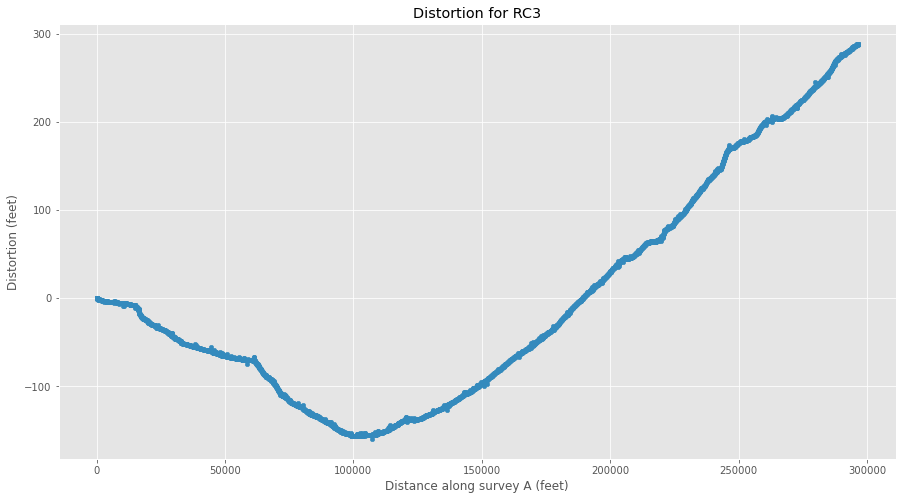

In [26]:
#### Plot_distortion
## Label 10

dsS.plot(kind='scatter', 
         x='wcA', y='dist', 
         figsize=[15,8], 
         xlabel='Distance along survey A (feet)',
         ylabel='Distortion (feet)', 
         title='Distortion for ' + dset)
# , ylim=[-160,0], xlim=[0,107500]
plt.show

### Uncomment to save the plot
# plt.savefig('./Distortion ', + dset + ,'.pdf')
plt.savefig('../results/Distortion_Graph_' + dset + '.png')

## Plot the Differencing

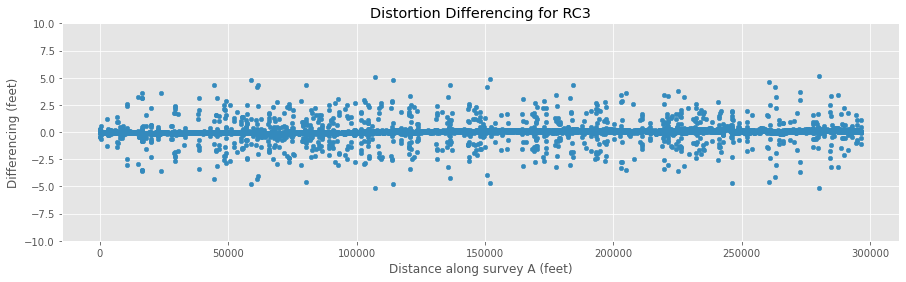

In [29]:
# Plot_diff
## Label 11

dsS.plot(kind='scatter', x='wcA', y='diff', 
         figsize=[15,4], ylim=[-10,10],
         xlabel='Distance along survey A (feet)',
         ylabel='Differencing (feet)', 
         title='Distortion Differencing for ' + dset)
# , ylim=[-160,0], xlim=[0,107500]
plt.show

### Uncomment to save the plot
plt.savefig('../results/Differencing_Graph_' + dset + '.png')

In [30]:
### Grid_Search
## Label 12

### Display grid search parameters

print(bigW, ' : bigW')
print(etMonoVal, ' : et')
print(psi, ' : psi')
print(i)
print(k)
print(len(S))  # <-- number of pairs found
print('Match % : ', round(len(S)/i * 100,2))


33  : bigW
5.3  : et
1.3  : psi
7900
7755
7633
Match % :  96.62
